In [1]:
import wrds
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import os
import pickle

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


# First draft - dispersion trade

require: 
1. option_name data for the names of tickers 
2. option_data for the option data and 
3. secutiry price from secprd2023

## Get secid of Indices and corresponding ETF


In [2]:
# Establish WRDS connection
db = wrds.Connection(wrds_username='changjulian17')

# Create cache directory if it doesn't exist
cache_dir = '../cache'
os.makedirs(cache_dir, exist_ok=True)

# Check if cached data exists
option_name_cache = f'{cache_dir}/option_name.csv'

if os.path.exists(option_name_cache):
    print("Loading cached option_name data...")
    option_name = pd.read_csv(option_name_cache)
else:
    print("Fetching option_name data from WRDS...")
    
    query = """
    SELECT 
        *
    FROM optionm.secnmd
    """
    
    option_name = db.raw_sql(query)
    db.close()
    
    # Cache the results
    option_name.to_csv(option_name_cache, index=False)
    print(f"Cached option_name data to {option_name_cache}")

print(f"Retrieved {len(option_name)} option records")
print(option_name.head())
option_name[option_name['ticker'] == 'SPY']

Loading library list...
Done
Loading cached option_name data...
Retrieved 265203 option records
    secid effect_date     cusip ticker class                      issuer  \
0  5001.0  1996-01-02  00078110  ABSIE   NaN          ABS INDUSTRIES INC   
1  5001.0  2007-03-08  00078110   ZZZZ   NaN                ABS INDS INC   
2  5002.0  1996-01-01  00103010  AELNA   NaN       AEL INDUSTRIES - CI A   
3  5003.0  1996-01-01  00103810   AFAP   NaN  AFA PROTECTIVE SYSTEMS INC   
4  5003.0  1999-07-08  00103810  AFAPE   NaN  AFA PROTECTIVE SYSTEMS INC   

  issue     sic  
0   NaN     NaN  
1   COM  3462.0  
2   NaN     NaN  
3   NaN     NaN  
4   NaN     NaN  


,secid,effect_date,cusip,ticker,class,issuer,issue,sic
5563,7571.0,1996-10-28,81750M10,SPY,NaN,SERENPET INC,NaN,NaN
10623,100155.0,2009-11-02,32299W10,SPY,I,SPDR TRUST SERIES 1,INTRADAY,9999.0
71921,109820.0,1996-01-02,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,NaN
71922,109820.0,2000-11-28,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,6726.0
71923,109820.0,2010-01-28,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,UNIT SER 1 S&P,6726.0
71924,109820.0,2010-07-08,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6726.0
71925,109820.0,2017-12-26,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6733.0
71926,109820.0,2020-07-27,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SSGA SPDR S&P 500,NaN
71927,109820.0,2021-02-25,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SPDR S&P 500 ETF TRU,NaN
71928,109820.0,2021-03-01,78462F10,SPY,NaN,SSGA ACTIVE TRUST,S&P 500 ETF TRUST ET,NaN


In [3]:
# 1. Get secids for target tickers from secnmd with issuer filtering
target_tickers = ['SPY', 'XLK', 'XLY', 'XLF', 'XLV']
target_issuers = ['SPDR S&P 500 ETF TR', 'SECTOR SPDR TR', 
                  'SELECT SECTOR SPDR TR']

# Filter secnmd for target tickers AND issuers
target_securities = option_name[
    (option_name['ticker'].isin(target_tickers)) &
    (option_name['issuer'].isin(target_issuers))
]

target_secids = target_securities['secid'].tolist()

# print(f"Found {len(target_secids)} secids for target tickers and issuers:")
target_securities = target_securities[['secid', 'ticker']].drop_duplicates()
secid_list = target_securities['secid'].tolist()
secid_list

[109820.0, 110008.0, 110010.0, 110012.0, 110014.0]

## Get Option data for short listed secid

In [4]:
# Convert secids to string format for SQL IN clause
secid_list_str = ','.join([f"'{secid}'" for secid in secid_list])

# Cache option data
option_data_cache = f'{cache_dir}/filtered_option_data.pkl'

if os.path.exists(option_data_cache):
    print("Loading cached option data...")
    with open(option_data_cache, 'rb') as f:
        filtered_option_data = pickle.load(f)
else:
    print("Fetching option data from WRDS...")
    
    query = f"""
    SELECT 
        *
    FROM optionm.opprcd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    ORDER BY date, secid, strike_price, cp_flag
    """
    
    filtered_option_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    with open(option_data_cache, 'wb') as f:
        pickle.dump(filtered_option_data, f)
    print(f"Cached option data to {option_data_cache}")

print(f"Retrieved {len(filtered_option_data)} option records for target secids")
print(filtered_option_data.head())

Loading cached option data...
Retrieved 2394422 option records for target secids
      secid        date             symbol symbol_flag      exdate  \
0  109820.0  2023-01-03  SPY 241220C120000           1  2024-12-20   
1  109820.0  2023-01-03  SPY 241220P120000           1  2024-12-20   
2  109820.0  2023-01-03  SPY 241220C130000           1  2024-12-20   
3  109820.0  2023-01-03  SPY 241220P130000           1  2024-12-20   
4  109820.0  2023-01-03  SPY 241220C140000           1  2024-12-20   

    last_date cp_flag  strike_price  best_bid  best_offer  ...     theta  \
0  2022-12-19       C      120000.0     260.5       265.5  ... -8.084044   
1  2023-01-03       P      120000.0      0.99        1.16  ... -1.457403   
2  2022-10-17       C      130000.0     251.5       256.5  ... -9.233222   
3  2022-12-29       P      130000.0       0.0        1.35  ... -0.995745   
4        <NA>       C      140000.0     242.5       247.5  ... -10.00525   

      optionid  cfadj  am_settlement  con

## Get the ETF OCHL (Open Close High Low)

In [5]:
# Cache security price data
security_data_cache = f'{cache_dir}/security_data.csv'

if os.path.exists(security_data_cache):
    print("Loading cached security price data...")
    security_data = pd.read_csv(security_data_cache, parse_dates=['date'])
else:
    print("Fetching security price data from WRDS...")
    db = wrds.Connection(wrds_username='changjulian17')
    
    query = f"""
    SELECT 
        *
    FROM optionm.secprd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    """
    
    security_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    security_data.to_csv(security_data_cache, index=False)
    print(f"Cached security data to {security_data_cache}")

print(f"Retrieved {len(security_data)} security price records")
print(security_data.head())

Loading cached security price data...
Retrieved 835 security price records
      secid       date       low    high   close       volume    return  \
0  109820.0 2023-01-03  377.8310  386.43  380.82   74850731.0 -0.004210   
1  109820.0 2023-01-04  380.0000  385.88  383.76   85934098.0  0.007720   
2  109820.0 2023-01-05  378.7600  381.84  379.38   76970456.0 -0.011413   
3  109820.0 2023-01-06  379.4127  389.25  388.08  104189603.0  0.022932   
4  109820.0 2023-01-09  387.6700  393.70  387.86   73978071.0 -0.000567   

   cfadj    open    cfret    shrout  
0    1.0  384.37  1.62005  932632.0  
1    1.0  383.18  1.62005  932632.0  
2    1.0  381.72  1.62005  927282.0  
3    1.0  382.61  1.62005  931982.0  
4    1.0  390.37  1.62005  929682.0  


In [6]:
security_data['secid'].unique()

array([109820., 110008., 110010., 110012., 110014.])

In [7]:
# Add ticker mapping to security data
secid_ticker_mapping = target_securities.set_index('secid')['ticker'].to_dict()
security_data['ticker'] = security_data['secid'].map(secid_ticker_mapping)

# Calculate average close price for each security
# ensure to only take mean dates for test period before 1 July 2023
cutoff_date = pd.to_datetime('2023-02-01')
security_data_before_july = security_data[security_data['date'] < cutoff_date]

avg_close_prices = security_data_before_july.groupby(['secid', 'ticker'])['close'].mean().reset_index()
avg_close_prices.columns = ['secid', 'ticker', 'avg_close']
avg_close_prices

,secid,ticker,avg_close
0,109820.0,SPY,394.6960
1,110008.0,XLV,134.1395
2,110010.0,XLY,138.3150
3,110012.0,XLF,35.5800
4,110014.0,XLK,130.0410


## Basic calculations 
assumed proportion (27 July 2025), estimated and scaled proportions:

| Sector                 | Ticker | Assumed Proportion | Estimated (%) | Scaled (%) |
| ---------------------- | ------ | ------------------ | ------------- | ---------- |
| Technology             | XLK    | 34.36%             | 30%           | 42.857%    |
| Financial Services     | XLF    | 13.67%             | 10%           | 14.2857%   |
| Consumer Cyclical      | XLY    | 10.54%             | 10%           | 14.2857%   |
| Communication Services | XLC    | 9.79%              | 10%           | 14.2857%   |
| Healthcare             | XLV    | 9.33%              | 10%           | 14.2857%   |

*won't be too exact since it is a snapshot and it should change over time too

show the market cap and implied notional for all components

SPY: 384.37\
XLK: 125.77\
XLV: 135.96\
XLY: 129.93\
XLF: 34.45

## Fundamental assumption
Volitility of S index is much lower than C component.
$$
{IV}_S \le \sum{{IV}_i}
$$
SPY should be represented by a proportionate constituents of sector ETF. Also so that the IV can be easily comparable i.e. 1 unit of SPY vol is comparable with one basket of C vol

$$
S_0 \times Q_0 = \sum{{C_i} \times Q_i} 
$$

Need to calculate delta as the scaling factor to get proportion of purchase of stocks.

Assumption
1. take only top 4 sectors of SPY and scale up to 100% of SPY give n by (scaled_weights)
2. fix the proportion of 4 sectors 


In [8]:
scaled_weights = {
    "SPY": 100,
    "XLK": 42.857,
    "XLF": 14.2857,
    "XLY": 14.2857,
    "XLC": 14.2857,
    "XLV": 14.2857
}

avg_close_prices['Scaled_Weight'] = avg_close_prices['ticker'].map(scaled_weights)
# Calculate relative position sizes
# coefficients = weights / prices * scaling_factor
vector = avg_close_prices['Scaled_Weight'].values / avg_close_prices['avg_close'].values * 20
vector_rounded = np.round(vector).astype(int)
# trial and error on the scaling factor to find a nice association
avg_close_prices['Vector (Scaled_Weight)'] = vector_rounded
avg_close_prices

,secid,ticker,avg_close,Scaled_Weight,Vector (Scaled_Weight)
0,109820.0,SPY,394.6960,100.0000,5
1,110008.0,XLV,134.1395,14.2857,2
2,110010.0,XLY,138.3150,14.2857,2
3,110012.0,XLF,35.5800,14.2857,8
4,110014.0,XLK,130.0410,42.8570,7


# Data Preparation
Prepare option daily data
1. add previous day's close for each row
2. only take regular 3rd friday options
3. calculate difference of strike to close for each row
4. 

In [9]:
# Function to check if a date is the 3rd Friday of the month
def is_third_friday(date):
    return date.weekday() == 4 and 15 <= date.day <= 21

# Find ATM strikes for each option based on previous day's close
simplified_cols = ['secid', 'date', 'symbol', 'exdate', 
                     'cp_flag', 'strike_price', 'best_bid', 'best_offer',
                     'impl_volatility']

# 1. Prepare previous day's close for each secid/date
security_data_sorted = security_data.sort_values(['secid', 'date'])
security_data_sorted['prev_close'] = security_data_sorted.groupby('secid')['close'].shift(1)

# 2. Merge previous day's close into option data
filtered_option_data = filtered_option_data[simplified_cols]
# filter non-regular options
filtered_option_data['exdate'] = pd.to_datetime(filtered_option_data['exdate'])
filtered_option_data['date'] = pd.to_datetime(filtered_option_data['date'])

# Filter for rows where exdate is the 3rd Friday of the month and within the first/last exdate range
filtered_option_data = filtered_option_data[
    filtered_option_data['exdate'].apply(is_third_friday) &
    (filtered_option_data['exdate'] >= filtered_option_data['exdate'].min()) &
    (filtered_option_data['exdate'] <= filtered_option_data['exdate'].max())
]

filtered_option_data = filtered_option_data.merge(
    security_data_sorted[['secid', 'date', 'prev_close']],
    on=['secid', 'date'],
    how='left'
)

# Calculate the absolute difference between strike and previous close
filtered_option_data['abs_diff'] = np.abs(filtered_option_data['strike_price']/1000 - filtered_option_data['prev_close'])
filtered_option_data = filtered_option_data.dropna(subset=['prev_close'])   # remove first day data with no previous close
filtered_option_data['ticker'] = filtered_option_data['secid'].map(secid_ticker_mapping)    # map secid to ticker


In [10]:
# df = filtered_option_data.copy()
# df[(filtered_option_data['date'] == pd.to_datetime('2023-03-10'))]

filtered_option_data.exdate.unique()

<DatetimeArray>
['2024-12-20 00:00:00', '2023-03-17 00:00:00', '2023-06-16 00:00:00',
 '2023-09-15 00:00:00', '2023-02-17 00:00:00', '2025-12-19 00:00:00',
 '2023-12-15 00:00:00', '2023-04-21 00:00:00', '2023-01-20 00:00:00',
 '2025-03-21 00:00:00', '2024-01-19 00:00:00', '2025-01-17 00:00:00',
 '2024-06-21 00:00:00', '2023-10-20 00:00:00', '2023-05-19 00:00:00',
 '2023-07-21 00:00:00', '2024-03-15 00:00:00', '2023-08-18 00:00:00',
 '2024-09-20 00:00:00', '2025-06-20 00:00:00', '2023-11-17 00:00:00',
 '2024-04-19 00:00:00']
Length: 22, dtype: datetime64[ns]

# Analysis and Trading functions

In [11]:
def prepare_option_data_for_iv(df, exdate_target, avg_close_prices, fudge_factor=2):
    """
    Prepare option data for a given expiry date for IV calculation.
    - Filters for the given expiry
    - Finds ATM strikes for each secid/date/cp_flag
    - Adds bid/ask columns with fudge factor
    - Merges ATM strike and vector columns
    """
    df = df[df['exdate'] == exdate_target].copy()
    # Find ATM strike for each secid, date, cp_flag
    atm_strike_idx = df.groupby(['secid', 'date', 'cp_flag'])['abs_diff'].idxmin().dropna()
    atm_strikes = df.loc[atm_strike_idx, ['secid', 'date', 'cp_flag', 'strike_price']]
    atm_strikes = atm_strikes.rename(columns={'strike_price': 'atm_strike_price'})

    # Remove old atm_strike_price if present, then merge new
    df = df.drop(columns=['atm_strike_price'], errors='ignore')
    df['bid'] = df['best_bid'] - fudge_factor * (df['best_offer'] - df['best_bid'])
    df['ask'] = df['best_offer'] + fudge_factor * (df['best_offer'] - df['best_bid'])
    df = df.merge(
        atm_strikes,
        on=['secid', 'date', 'cp_flag'],
        how='left'
    )
    df = df.drop(columns=['Vector (Scaled_Weight)'], errors='ignore')
    df = df.merge(
        avg_close_prices[['ticker', 'Vector (Scaled_Weight)']],
        on='ticker',
        how='left'
    )
    return df

def calculate_dispersion_ivs(df, avg_close_prices, trade_date, exdate_target, fudge_factor=2, vector_rounded=None):
    """
    Calculate SPY and basket implied volatilities and their difference for a given trade_date and exdate_target.
    Returns a tuple: (spy_iv, basket_iv, spread)
    """
    # Use the helper function to prepare the option data
    df_prepared = prepare_option_data_for_iv(df, exdate_target, avg_close_prices, fudge_factor=fudge_factor)
    
    # calculate spy iv
    spy_iv = df_prepared[(df_prepared['ticker'] == 'SPY') &
                         (df_prepared['date'] == trade_date) &
                         (df_prepared['strike_price'] == df_prepared['atm_strike_price'])]['impl_volatility'].mean()

    # calculate basket iv
    df_1 = df_prepared[(df_prepared['ticker'] != 'SPY') &
                       (df_prepared['date'] == trade_date) &
                       (df_prepared['strike_price'] == df_prepared['atm_strike_price'])].copy()
    df_1['weighted_iv'] = df_1['impl_volatility'] * df_1['Vector (Scaled_Weight)']
    basket_iv = df_1.groupby('ticker')['weighted_iv'].mean().sum() / vector_rounded.sum()
    
    spread = basket_iv - spy_iv
    return spy_iv, basket_iv, spread

def build_dispersion_trade(df, trade_date, exdate_target, avg_close_prices, vector_col='Vector (Scaled_Weight)', fudge_factor=2):
    """
    For a given exdate_target and trade_date, returns a DataFrame with trade instructions:
    - Sell 5 SPY ATM straddles (5 calls + 5 puts)
    - Buy basket ETF ATM straddles according to Vector (Scaled_Weight)
    Includes bid and ask columns for each trade.
    """
    trade_list = []

    # Prepare option data using the helper function (includes bid/ask columns)
    df = prepare_option_data_for_iv(df, exdate_target, avg_close_prices, fudge_factor=fudge_factor)

    # Sell 5 SPY ATM straddles (calls and puts)
    for cp_flag in ['C', 'P']:
        spy_row = df[
            (df['ticker'] == 'SPY') &
            (df['date'] == trade_date) &
            (df['exdate'] == exdate_target) &
            (df['strike_price'] == df['atm_strike_price']) &
            (df['cp_flag'] == cp_flag)
        ]
        if not spy_row.empty:
            trade_list.append({
                'ticker': 'SPY',
                'cp_flag': cp_flag,
                'action': 'SELL',
                'contracts': 5,
                'strike': spy_row.iloc[0]['atm_strike_price'],
                'exdate': exdate_target,
                'bid': spy_row.iloc[0]['bid'],
                'ask': spy_row.iloc[0]['ask']
            })
    # Buy basket ETF ATM straddles according to vector
    basket_tickers = [t for t in df['ticker'].unique() if t != 'SPY']
    for ticker in basket_tickers:
        contracts = int(df[df['ticker'] == ticker][vector_col].iloc[0])
        for cp_flag in ['C', 'P']:
            etf_row = df[
                (df['ticker'] == ticker) &
                (df['date'] == trade_date) &
                (df['exdate'] == exdate_target) &
                (df['strike_price'] == df['atm_strike_price']) &
                (df['cp_flag'] == cp_flag)
            ]
            if not etf_row.empty and contracts > 0:
                trade_list.append({
                    'ticker': ticker,
                    'cp_flag': cp_flag,
                    'action': 'BUY',
                    'contracts': contracts,
                    'strike': etf_row.iloc[0]['atm_strike_price'],
                    'exdate': exdate_target,
                    'bid': etf_row.iloc[0]['bid'],
                    'ask': etf_row.iloc[0]['ask']
                })
    return pd.DataFrame(trade_list)

def calculate_trade_cost(trade_df):
    """
    Calculate the total cost of all trades in the trade_df returned by build_dispersion_trade.
    For BUY: use 'ask' price, for SELL: use 'bid' price.
    Returns the total cost (positive means net outflow, negative means net inflow).
    """
    def row_cost(row):
        price = row['ask'] if row['action'] == 'BUY' else row['bid']
        # If price is nan, treat as 0
        price = 0 if pd.isna(price) else price
        # Option contracts are usually per 100 shares
        return row['contracts'] * price * 100 * (1 if row['action'] == 'BUY' else -1)
    return trade_df.apply(row_cost, axis=1).sum()

In [12]:


# Example usage:
trade_date = pd.to_datetime('2023-01-10')
exdate_target = pd.to_datetime('2023-02-17')
spy_iv, basket_iv, spread = calculate_dispersion_ivs(filtered_option_data, 
                                                     avg_close_prices, 
                                                     trade_date, 
                                                     exdate_target, 
                                                     fudge_factor=2, 
                                                     vector_rounded=vector_rounded)

print(f"spy iv: {spy_iv}, basket iv: {basket_iv},ratio: {spread}")

# Example usage:
trade_df = build_dispersion_trade(filtered_option_data, pd.Timestamp('2023-01-31'), pd.Timestamp('2023-02-17'), avg_close_prices)
total_cost = calculate_trade_cost(trade_df)
print(f"Total cost of trade: {total_cost:2f}")

spy iv: 0.20603749999999998, basket iv: 0.1943817708333333,ratio: -0.011655729166666684
Total cost of trade: 1703.000000


In [13]:
# import matplotlib.pyplot as plt

# # Get all unique 3rd Friday expiry dates in 2023
# df = filtered_option_data[filtered_option_data['exdate'] <= pd.to_datetime('2023-05-31')]
# third_fridays = [x for x in sorted(df['exdate'].unique()) if is_third_friday(x)]
# print(third_fridays)
# n = len(third_fridays)
# ncols = 2
# nrows = (n + 1) // ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharex=False)
# axes = axes.flatten()

# for i, exdate_target in enumerate(third_fridays):
#     trade_date = exdate_target - pd.DateOffset(months=3)
#     min_date = filtered_option_data['date'].min()
#     if trade_date < min_date:
#         trade_date = min_date
#     date_range = pd.date_range(start=trade_date, end=exdate_target, freq='B')
#     spy_ivs, basket_ivs, spreads, dates = [], [], [], []
#     for dt in date_range:
#         try:
#             spy_iv, basket_iv, spread = calculate_dispersion_ivs(
#                 filtered_option_data, 
#                 avg_close_prices, 
#                 dt, 
#                 exdate_target, 
#                 fudge_factor=2, 
#                 vector_rounded=vector_rounded
#             )
#             if not (np.isnan(spy_iv) or np.isnan(basket_iv) or np.isnan(spread)):
#                 spy_ivs.append(spy_iv)
#                 basket_ivs.append(basket_iv)
#                 spreads.append(spread)
#                 dates.append(dt)
#         except Exception:
#             continue
#     if dates:
#         ax = axes[i]
#         ax.plot(dates, spy_ivs, label="SPY IV")
#         ax.plot(dates, basket_ivs, label="Basket IV")
#         ax.plot(dates, spreads, label="Spread", linestyle='--')
#         ax.set_title(f"Expiry: {exdate_target.date()}")
#         ax.set_xlabel("Date")
#         ax.set_ylabel("Implied Volatility")
#         ax.legend(fontsize='small')
#         ax.grid(True)

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()

[Timestamp('2023-01-20 00:00:00'), Timestamp('2023-02-17 00:00:00'), Timestamp('2023-03-17 00:00:00'), Timestamp('2023-04-21 00:00:00'), Timestamp('2023-05-19 00:00:00')]
spy iv: 0.215356, basket iv: 0.20311916666666666, ratio: -0.012236833333333336, cost: 1417.0000000000027
spy iv: 0.21392499999999998, basket iv: 0.20191427083333335, ratio: -0.012010729166666623, cost: 1133.0000000000023
spy iv: 0.206519, basket iv: 0.18972202083333334, ratio: -0.01679697916666667, cost: 1090.9999999999986
spy iv: 0.217542, basket iv: 0.19685316666666666, ratio: -0.02068883333333335, cost: 1965.0000000000016
spy iv: 0.21548099999999998, basket iv: 0.2015399583333333, ratio: -0.013941041666666681, cost: 970.9999999999998
spy iv: 0.2315775, basket iv: 0.20913043749999996, ratio: -0.02244706250000003, cost: 1297.0000000000007
spy iv: 0.1601885, basket iv: 0.15860929166666665, ratio: -0.0015792083333333595, cost: 1565.0000000000007
spy iv: 0.138771, basket iv: 0.13353795833333332, ratio: -0.00523304166666

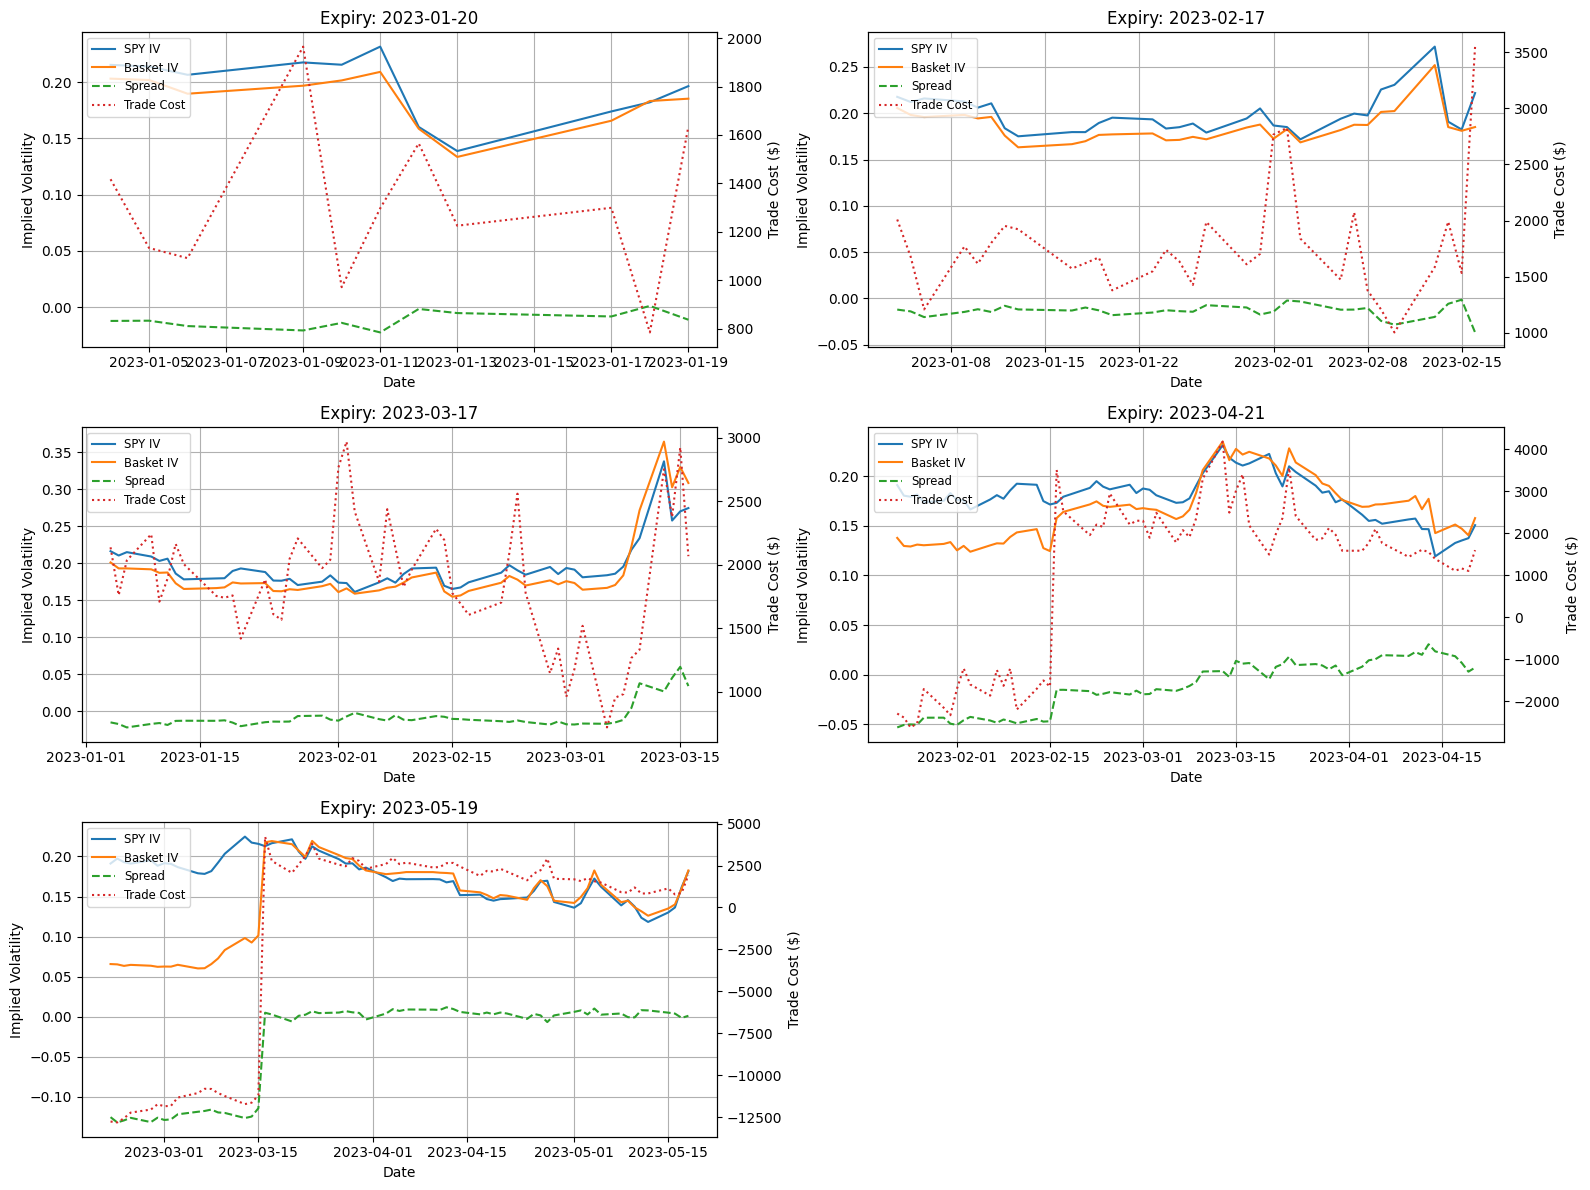

In [14]:
# Get all unique 3rd Friday expiry dates in 2023
df = filtered_option_data[filtered_option_data['exdate'] <= pd.to_datetime('2023-05-31')]
third_fridays = [x for x in sorted(df['exdate'].unique()) if is_third_friday(x)]
print(third_fridays)
n = len(third_fridays)
ncols = 2
nrows = (n + 1) // ncols


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharex=False)
axes = axes.flatten()

for i, exdate_target in enumerate(third_fridays):
    trade_date = exdate_target - pd.DateOffset(months=3)
    min_date = df['date'].min()
    if trade_date < min_date:
        trade_date = min_date
    date_range = pd.date_range(start=trade_date, end=exdate_target, freq='B')
    spy_ivs, basket_ivs, spreads, costs, dates = [], [], [], [], []
    for dt in date_range:
        try:
            spy_iv, basket_iv, spread = calculate_dispersion_ivs(
                df, 
                avg_close_prices, 
                dt, 
                exdate_target, 
                fudge_factor=2, 
                vector_rounded=vector_rounded
            )
            # print(spy_iv)
            trade_df = build_dispersion_trade(
                df, 
                dt, 
                exdate_target, 
                avg_close_prices
            )
            total_cost = calculate_trade_cost(trade_df)
            # print(f"spy iv: {spy_iv}, basket iv: {basket_iv}, ratio: {spread}, cost: {total_cost}")
            if all(pd.notna(x) for x in [spy_iv, basket_iv, spread]):
                spy_ivs.append(spy_iv)
                basket_ivs.append(basket_iv)
                spreads.append(spread)
                costs.append(total_cost)
                dates.append(dt)
        except Exception:
            print(f"Error processing date {dt} for expiry {exdate_target}: {e}")
            break
    if dates:
        ax = axes[i]
        ax.plot(dates, spy_ivs, label="SPY IV")
        ax.plot(dates, basket_ivs, label="Basket IV")
        ax.plot(dates, spreads, label="Spread", linestyle='--')
        ax2 = ax.twinx()
        ax2.plot(dates, costs, label="Trade Cost", color='tab:red', linestyle=':')
        ax.set_title(f"Expiry: {exdate_target.date()}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Implied Volatility")
        ax2.set_ylabel("Trade Cost ($)")
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, fontsize='small', loc='upper left')
        ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()